In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);
    plt.yscale('log')

## CoinMetrics

In [4]:
data = OrderedDict()

# Список финансовых инструментов в портфеле
TIKERS = ['BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['PriceUSD']

In [11]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2010, 7, 21)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 3, 15)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'price'}, axis=1)
    print(data[tiker].head())

               price
date                
2010-07-21  0.079193
2010-07-22  0.058470
2010-07-23  0.060593
2010-07-24  0.054540
2010-07-25  0.050541


In [12]:
data['BTC'] = data['BTC'][0:len(data['BTC']):7]

In [13]:
data['BTC'].tail()

,price
date,
2020-02-12,10360.135223
2020-02-19,9636.002299
2020-02-26,8798.888949
2020-03-04,8756.369572
2020-03-11,7939.341335


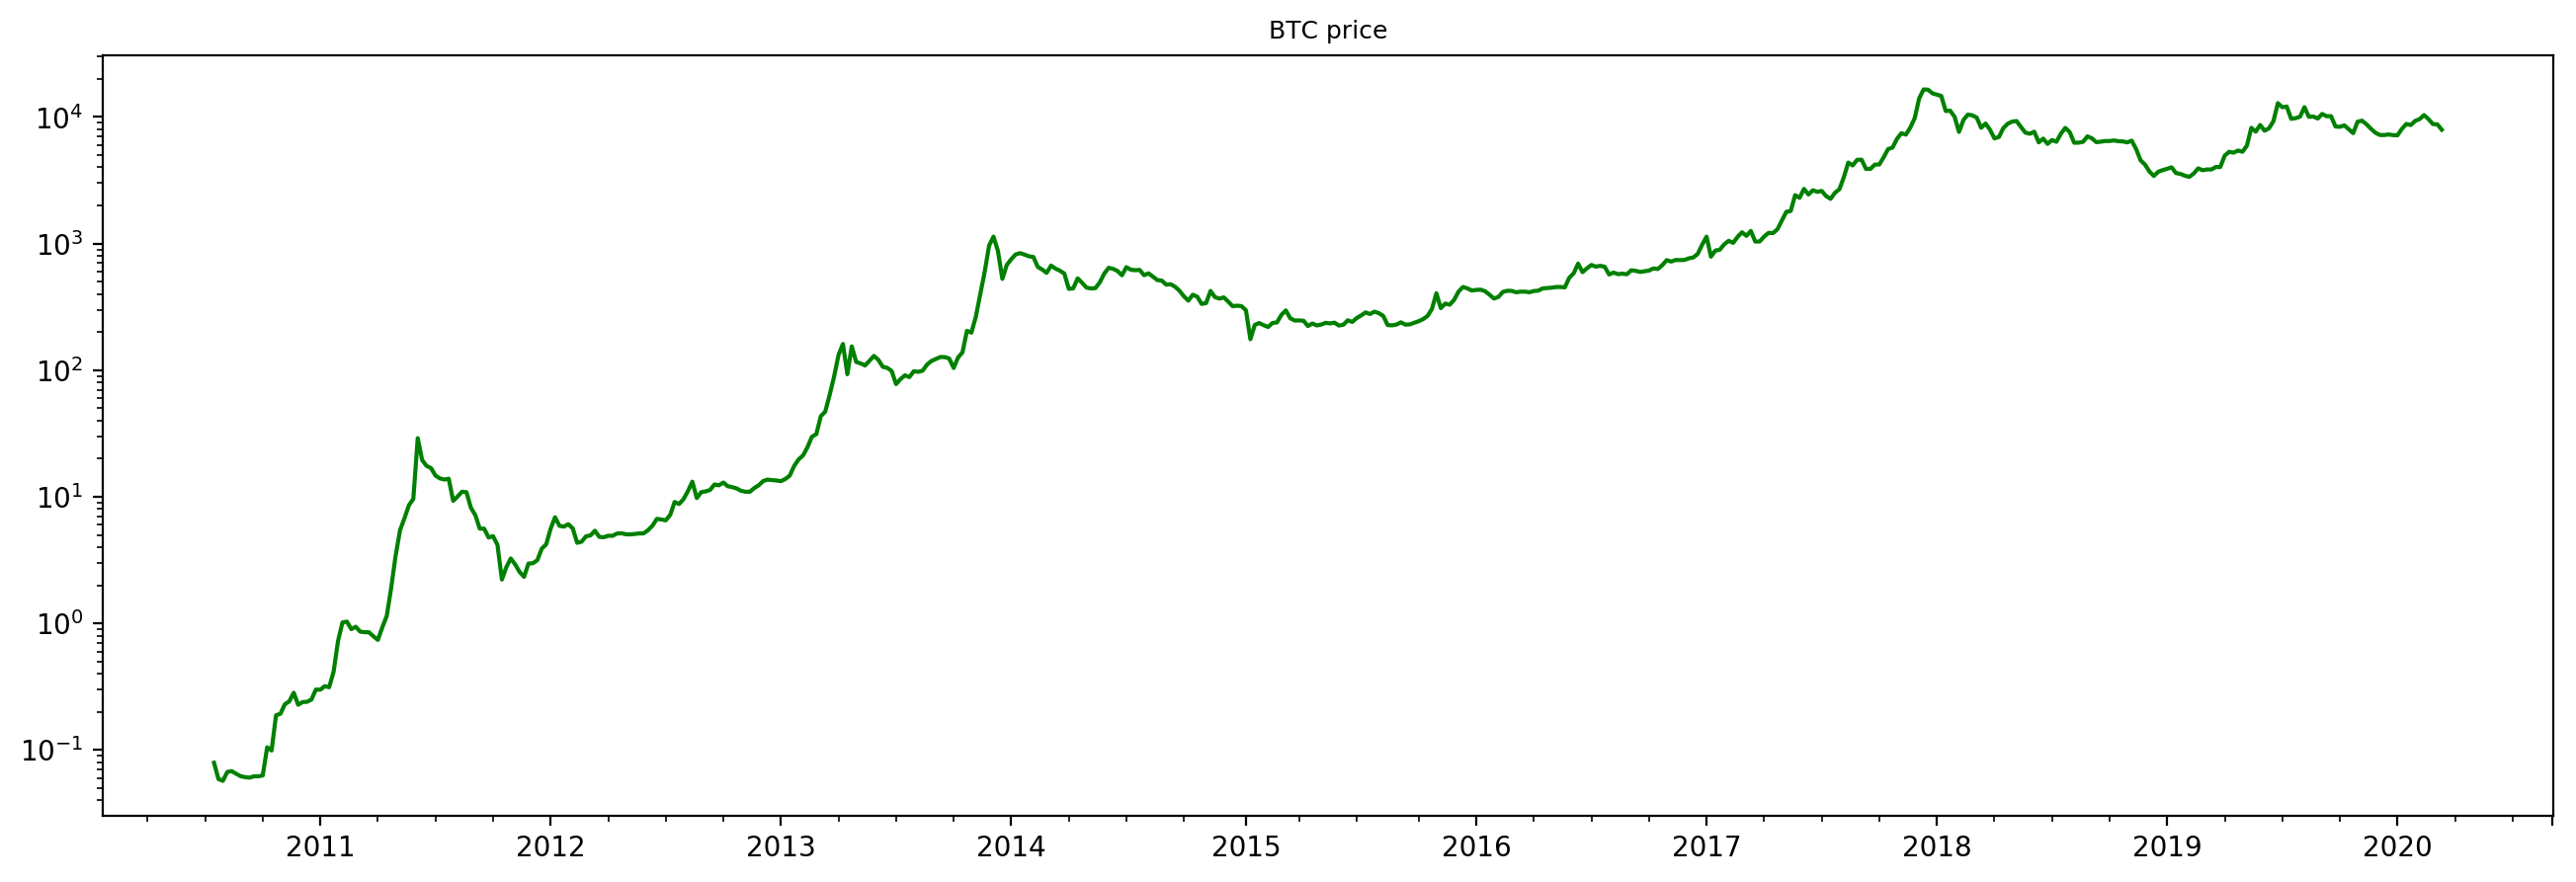

7939.34133477499


In [14]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
data['BTC']['price'].plot(color='g')
ax.set_xlabel('')
#ax.tick_params(axais = 'x', direction = 'out')

#plt.legend()
#plt.yscale('log')
plt.title('BTC price', fontsize = 9)
plt.yscale('log')
plt.show()

print(data['BTC']['price'][-1])

# FED Balance sheet

In [118]:
mb = pd.read_csv('data/MB.csv', sep=";", index_col = 'date', parse_dates=['date'])

In [119]:
mb.head()

,BOGMBASEW
date,
2008-06-04,840843.0
2008-06-11,837637.0
2008-06-18,837637.0
2008-06-25,842914.0
2008-07-02,842914.0


In [120]:
mb.tail()

,BOGMBASEW
date,
2020-02-12,3453798.0
2020-02-19,3438834.0
2020-02-26,3438834.0
2020-03-04,3530486.0
2020-03-11,3530486.0


In [121]:
mb['BTC'] = data['BTC']['price']

In [122]:
mb.head()

,BOGMBASEW,BTC
date,,
2008-06-04,840843.0,NaN
2008-06-11,837637.0,NaN
2008-06-18,837637.0,NaN
2008-06-25,842914.0,NaN
2008-07-02,842914.0,NaN


In [123]:
mb = mb.dropna()

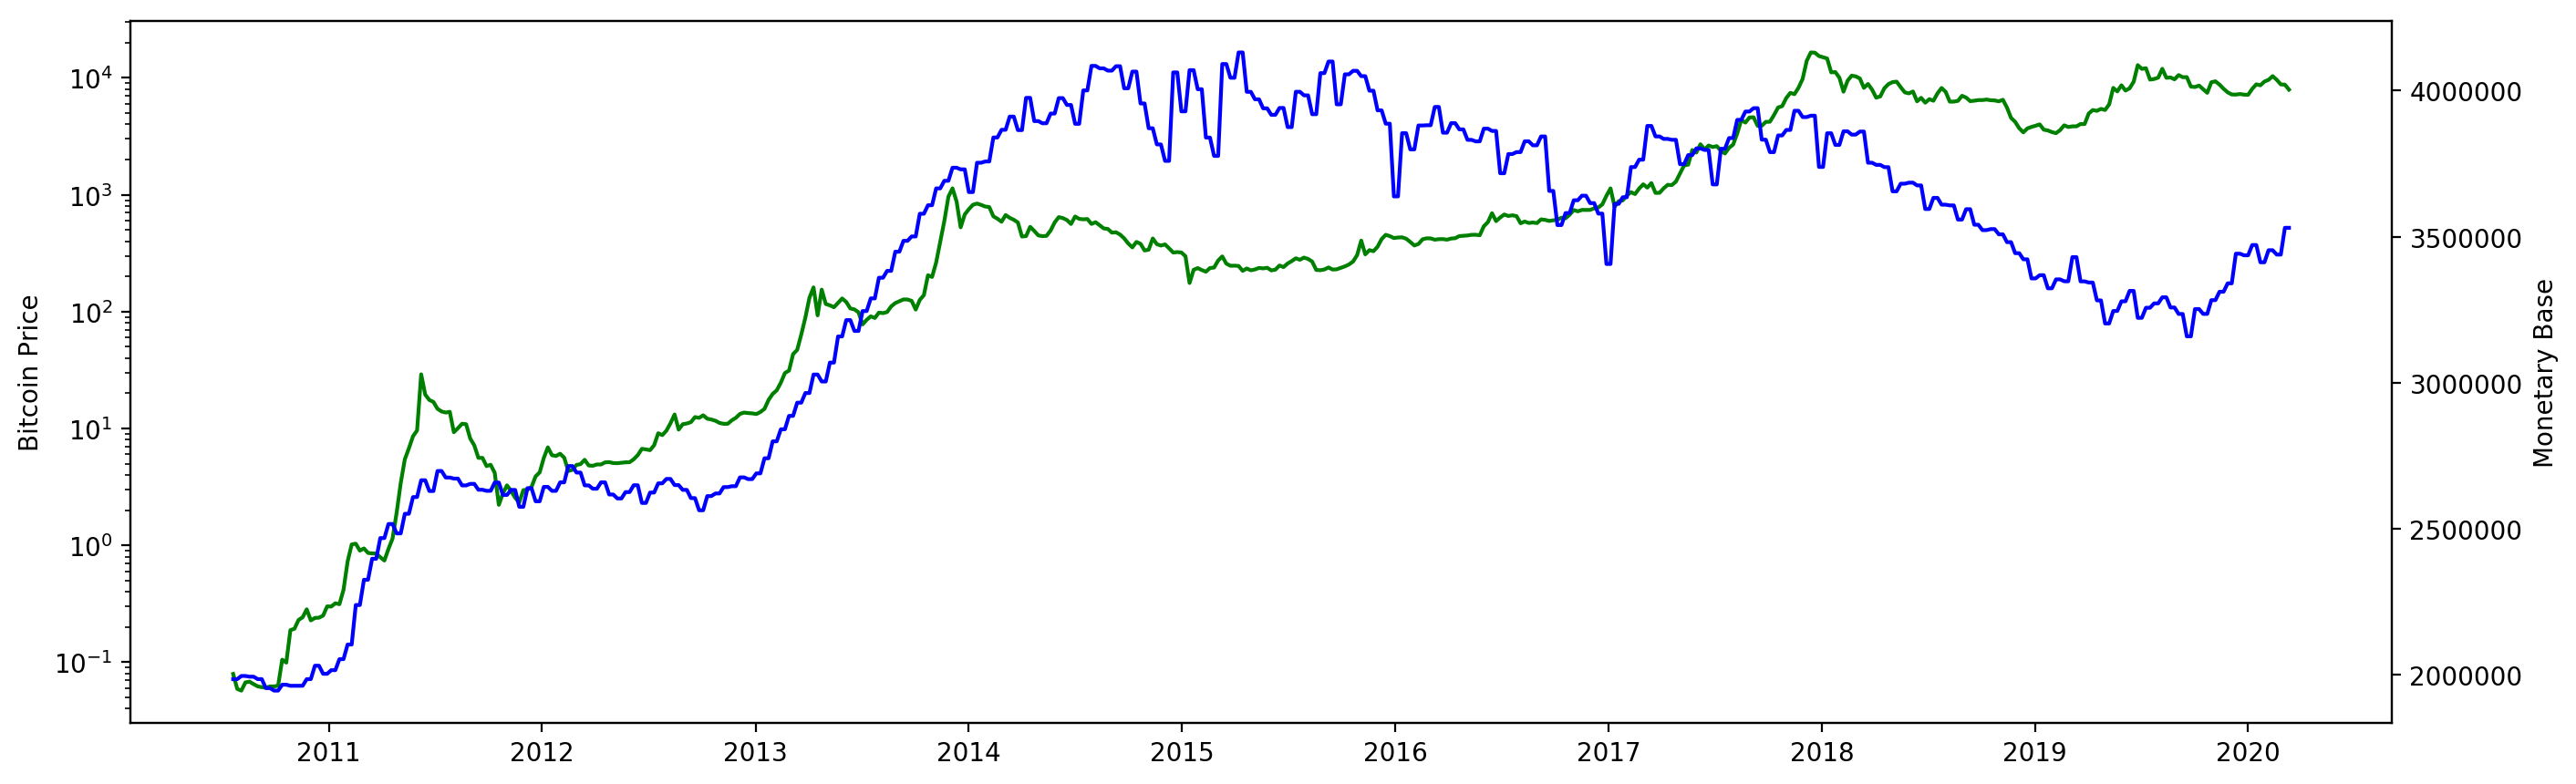

In [124]:
fig, ax = plt.subplots(figsize=[16, 5])

ax.plot(mb['BTC'], color='g')
ax.set_xlabel('')
ax.set_ylabel('Bitcoin Price')
#ax.legend(('Price USD'))
#ax.tick_params(axais = 'x', direction = 'out')

#plt.yscale('log')
#plt.title('BTC price', fontsize = 9)
plt.yscale('log')

ax2=ax.twinx()
ax2.plot(mb['BOGMBASEW'], color='blue')
ax2.set_ylabel('Monetary Base')

#plt.legend()

plt.show()

In [125]:
fig.savefig('price&monetary_base.png', transparent=False, dpi=500, bbox_inches="tight")

In [130]:
mb.corr(method='pearson')

,BOGMBASEW,BTC
BOGMBASEW,1.000000,0.551761
BTC,0.551761,1.000000


In [127]:
mb.corr(method='pearson').values[0][1]

0.23106108151215096

In [128]:
corr_list = []
corr_list.append(mb.corr(method='pearson').values[0][1])

In [129]:
for shift in tqdm(range(0, 109)):
    mb.BOGMBASEW = mb.BOGMBASEW.shift(1)
    fed.dropna()
    corr_list.append(mb.corr(method='pearson').values[0][1])

100%|██████████| 109/109 [00:00<00:00, 415.50it/s]


In [102]:
#corr_list

[0.23106108151215096,
 0.23510452538643312,
 0.23923301199810765,
 0.24337096818690626,
 0.246834488207815,
 0.25029601514407823,
 0.25315853563110824,
 0.2558214418839479,
 0.25860603900128043,
 0.26139074596216577,
 0.26463224044668593,
 0.2681542496714768,
 0.27174806803278767,
 0.27554274873150253,
 0.2789574708948538,
 0.28244474089824406,
 0.28548907886656116,
 0.2884923606510106,
 0.29077742355559655,
 0.2936026297272818,
 0.29650115229771984,
 0.2993038939705228,
 0.3018309980980832,
 0.30436713860320763,
 0.30756815989724073,
 0.31143700112984013,
 0.31500224468432597,
 0.3185513058343378,
 0.32212436802755384,
 0.32547928379591556,
 0.32854659718822843,
 0.33211378556125215,
 0.33545559062438673,
 0.3391673391628144,
 0.3431811210415917,
 0.3471117046453285,
 0.35108370900962715,
 0.35512465302564605,
 0.3586087512081921,
 0.36165493827608763,
 0.3638516592684496,
 0.3657606286529127,
 0.36764241740344783,
 0.36968904431385413,
 0.3712253940000781,
 0.37347806301425923,
 0.37

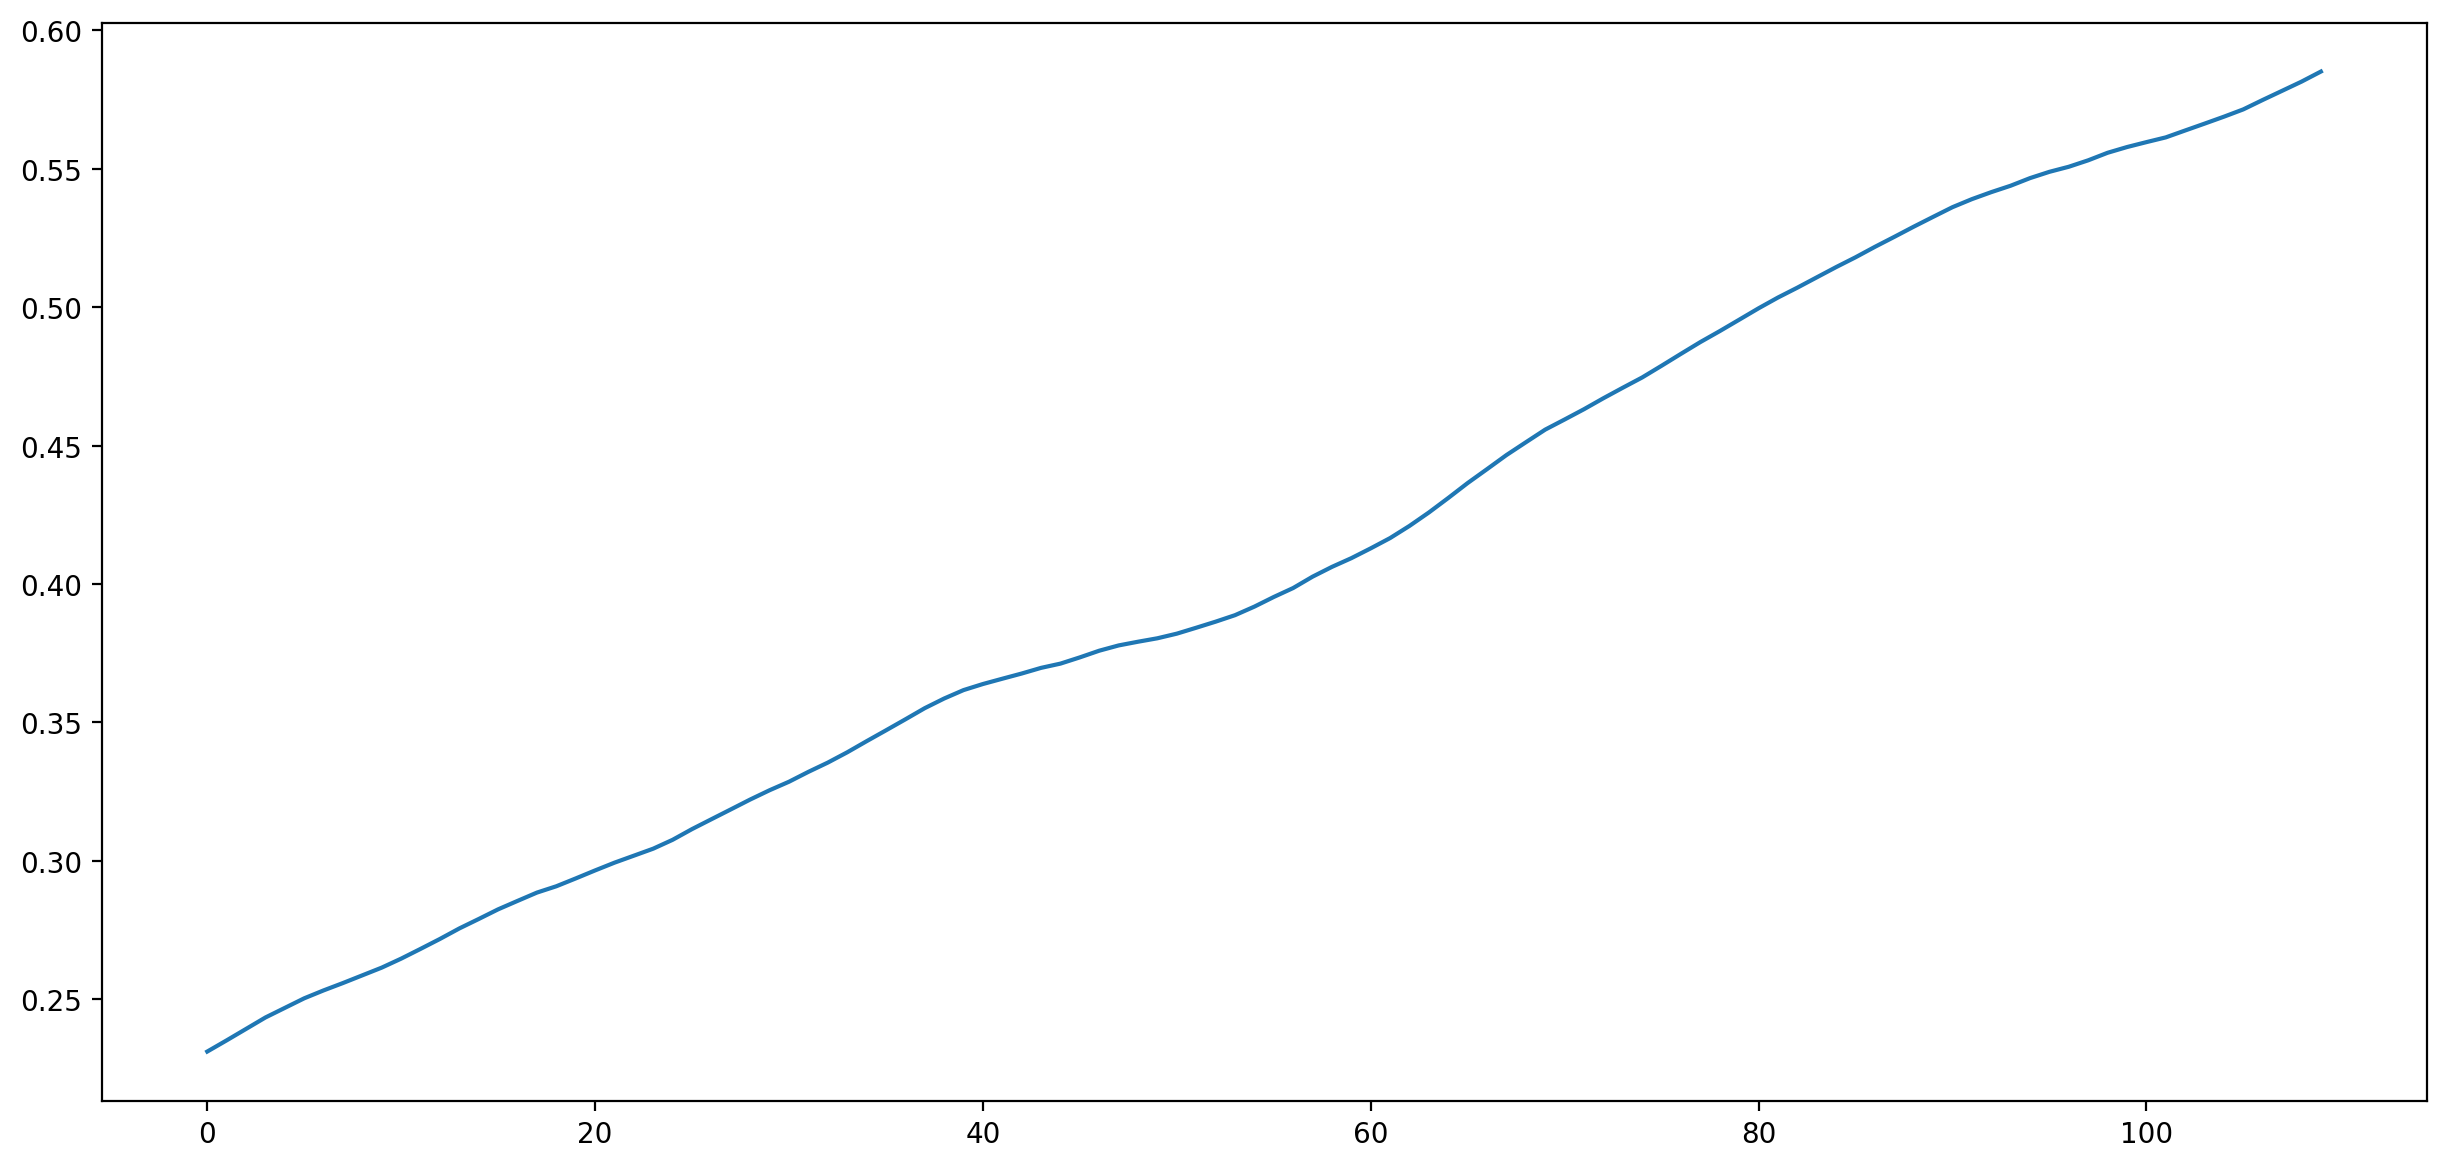

In [100]:
xlist = range(0, 110)
ylist = corr_list
plt.plot(xlist, ylist)
plt.show()

In [65]:
#corr_list

In [49]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2010, 10, 15)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 3, 11)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'price'}, axis=1)
    print(data[tiker].head())

               price      NVTAdj    NVTAdj90
date                                        
2010-10-15  0.105000   52.689023  154.643925
2010-10-16  0.101000   44.927385  144.681892
2010-10-17  0.102000  219.478535  147.263082
2010-10-18  0.102400   81.493029  145.972987
2010-10-19  0.097545   87.839037  137.869691


In [50]:
neg_corr_list = []
for shift in tqdm(range(0, 300)):
    data['BTC'].NVTAdj90 = data['BTC'].NVTAdj90.shift(-1)
    data['BTC'].dropna()
    neg_corr_list.append(data['BTC'].corr(method='pearson').values[0][2])

100%|██████████| 300/300 [00:00<00:00, 1003.49it/s]


In [51]:
neg_corr_list.reverse()

In [63]:
#neg_corr_list

In [53]:
final_list = neg_corr_list + corr_list

In [59]:
len(final_list)

601

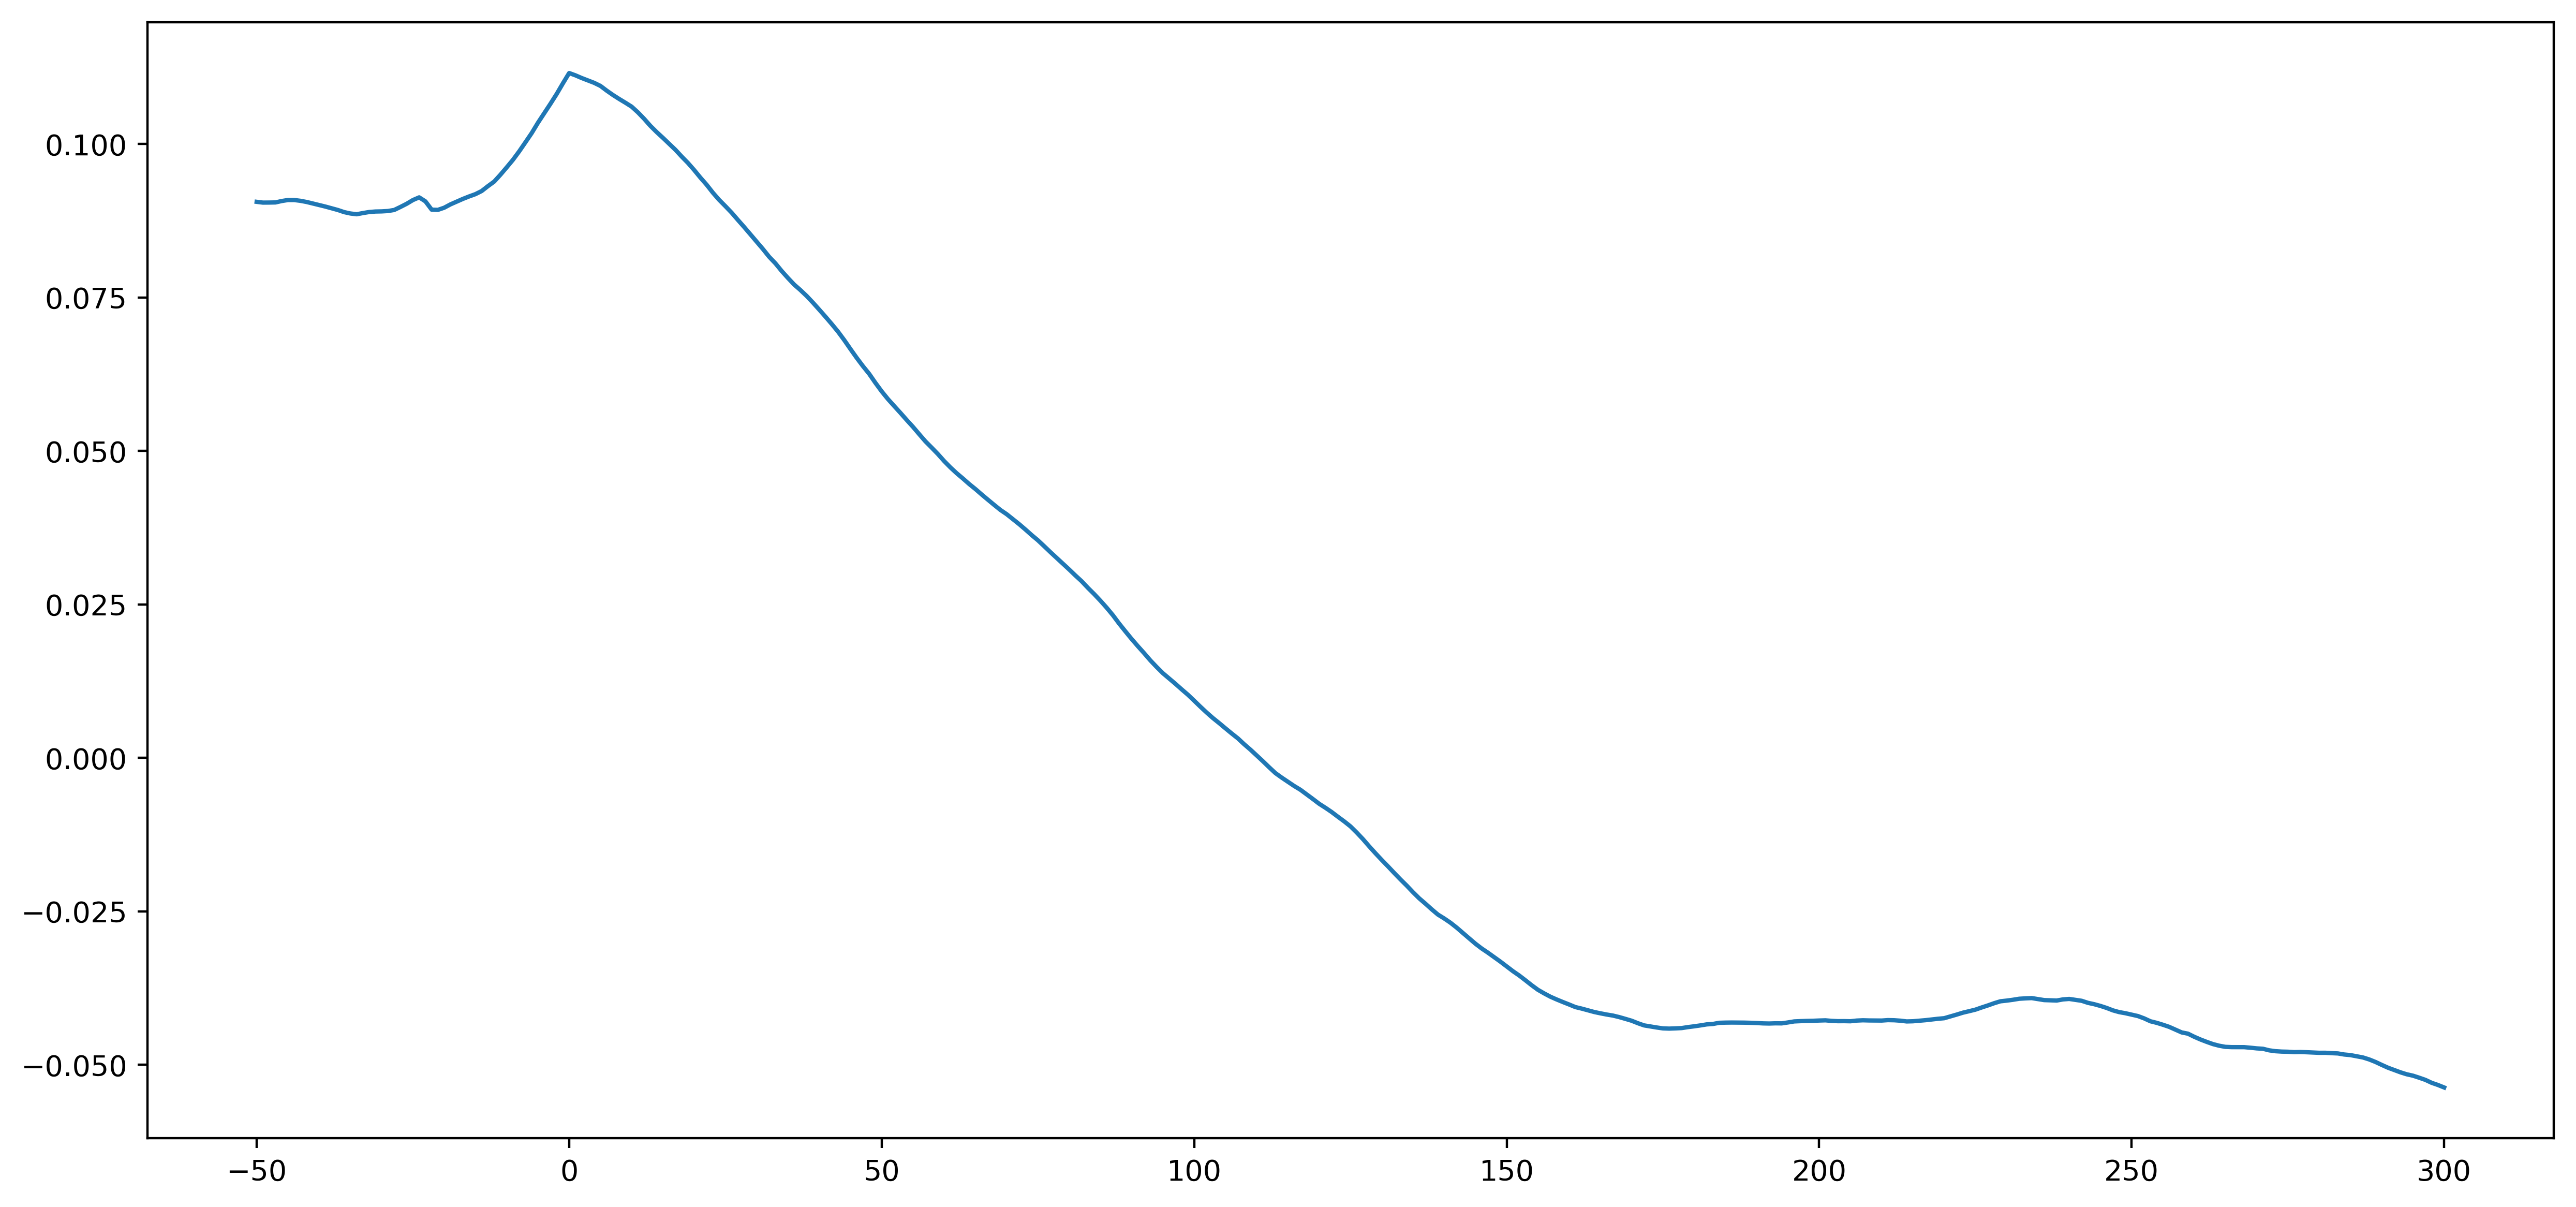

In [60]:
xlist = range(-50, 301)
ylist = final_list[250:601]
plt.plot(xlist, ylist)
plt.show()